In [1]:
import numpy as np
import pickle
import pandas as pd
from keras.layers import Dense, Activation, BatchNormalization, Dropout, Lambda, Input
from keras.models import Model, load_model, Sequential
from keras.optimizers import adam
from sklearn.naive_bayes import GaussianNB
from matplotlib import pyplot as plt
from lightgbm.basic import Booster
from sklearn.metrics import roc_auc_score, roc_curve

Using TensorFlow backend.


In [2]:
df = pd.read_csv('train.csv')

In [3]:
X = df.drop(columns=['ID_code', 'target'])
y = df['target']
y_cat = np.array([y, 1-y]).T

In [4]:
model_NB = pickle.load(open('naive_bayes_all_data.pk', 'rb'))

In [5]:
model_MLP_Keras = load_model('MLP_keras_all_data.h5')

In [6]:
model_LGBM = pickle.load(open('lgmb_model_all_data.pkl', 'rb'))

In [7]:
def predict(models, data):
    predictions = []
    for model in models:
        if type(model) == GaussianNB:
            print('Predicting Naive Bayes...')
            predictions.append(model.predict_proba(data)[:,1])
        if type(model) == Sequential:
            print('Predicting Keras MLP...')
            predictions.append(model.predict(data, verbose=1)[:,0])
        if type(model) == Booster:
            print('Predicting LGBM...')
            predictions.append(model.predict(data))
    return np.array(predictions).T

In [8]:
models = [model_NB, model_MLP_Keras, model_LGBM]

In [9]:
predictions = predict(models, X)

Predicting Naive Bayes...
Predicting Keras MLP...
200000/200000 [==============================] - 3s 13us/step
Predicting LGBM...


In [10]:
def plot_hists(predictions, N = 50):
    plt.figure(figsize=(20,6))
    colors = ['r', 'b', 'y']
    for i in range(predictions.shape[1]):
        hist = np.histogram(np.log(predictions[:,i]/(1-predictions[:,i])), N)
        # _ = plt.hist(np.log(predictions[:,i]/(1-predictions[:,i])), N, label=str(type(models[i])))
        plt.plot(np.linspace(hist[1][0], hist[1][-1], N), hist[0]/(hist[1][1]-hist[1][0]), label=str(type(models[i])), c=colors[i])
    plt.legend()
    plt.show()

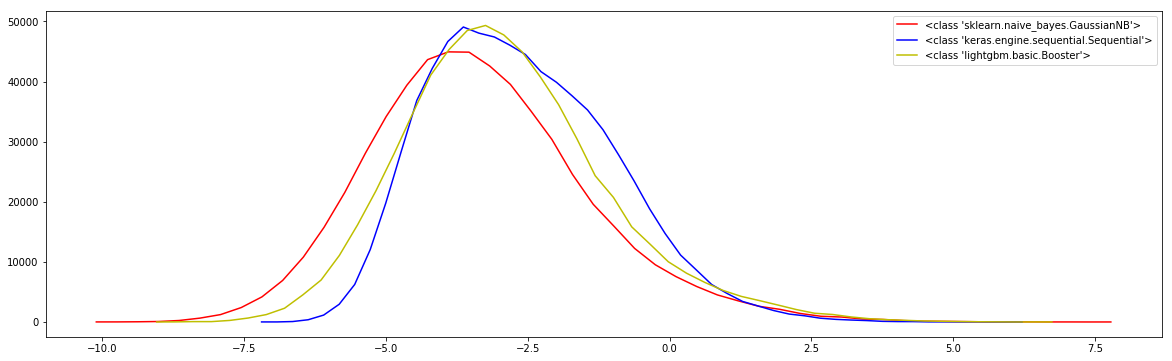

In [11]:
plot_hists(predictions)

In [13]:
model = Sequential()
model.add(Dense(10,input_shape=(predictions.shape[1],), activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                40        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 22        
Total params: 62
Trainable params: 62
Non-trainable params: 0
_________________________________________________________________


In [14]:
batch_size = 256
optimizer = adam(lr=1e-4)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.fit(predictions, y_cat, 
          batch_size=batch_size, 
          epochs=100, 
          verbose=1)

Epoch 1/100
200000/200000 [==============================] - 1s 6us/step - loss: 0.6392 - acc: 0.8069
Epoch 2/100
200000/200000 [==============================] - 1s 5us/step - loss: 0.5137 - acc: 0.8995
Epoch 3/100
200000/200000 [==============================] - 1s 5us/step - loss: 0.4059 - acc: 0.9008
Epoch 4/100
200000/200000 [==============================] - 1s 5us/step - loss: 0.3172 - acc: 0.9197
Epoch 5/100
200000/200000 [==============================] - 1s 5us/step - loss: 0.2589 - acc: 0.9281
Epoch 6/100
200000/200000 [==============================] - 1s 5us/step - loss: 0.2254 - acc: 0.9300
Epoch 7/100
200000/200000 [==============================] - 1s 5us/step - loss: 0.2075 - acc: 0.9308
Epoch 8/100
200000/200000 [==============================] - 1s 5us/step - loss: 0.1983 - acc: 0.9311
Epoch 9/100
200000/200000 [==============================] - 1s 5us/step - loss: 0.1934 - acc: 0.9313
Epoch 10/100
200000/200000 [==============================] - 1s 5us/step - loss: 

In [16]:
ensamble_prediction = model.predict(predictions, verbose=1)[:,0]

200000/200000 [==============================] - 1s 6us/step


In [18]:
roc_auc_score(y, ensamble_prediction)

0.9271891996042441

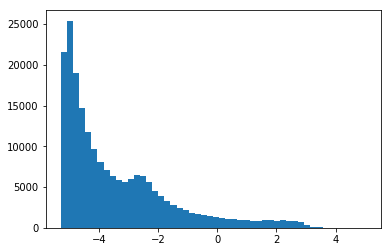

In [19]:
_ = plt.hist(np.log(ensamble_prediction/(1-ensamble_prediction)), 50)

# Test

In [20]:
X_test = pd.read_csv('test.csv').set_index('ID_code')

In [21]:
predictions_test = predict(models, X_test)

Predicting Naive Bayes...
Predicting Keras MLP...
200000/200000 [==============================] - 3s 13us/step
Predicting LGBM...


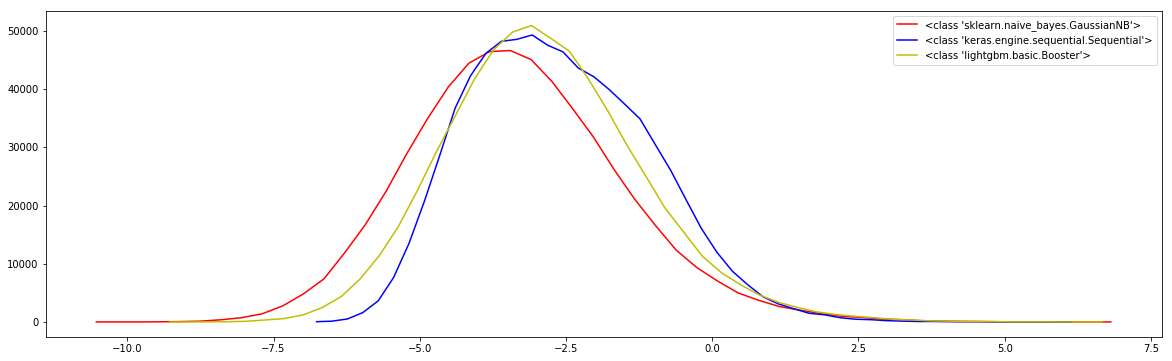

In [23]:
plot_hists(predictions_test)

In [24]:
ensamble_prediction_test = model.predict(predictions_test, verbose=1)[:,0]

200000/200000 [==============================] - 1s 6us/step


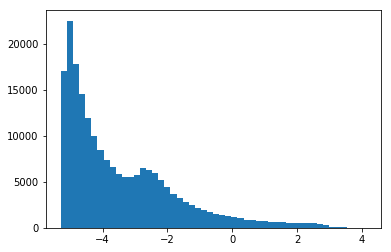

In [25]:
_ = plt.hist(np.log(ensamble_prediction_test/(1-ensamble_prediction_test)), 50)

# Submit

In [26]:
df_test = pd.read_csv('test.csv').set_index('ID_code')
df_test['target'] = ensamble_prediction_test

In [27]:
df_test[['target']].head()

,target
ID_code,
test_0,0.112384
test_1,0.249145
test_2,0.085106
test_3,0.426339
test_4,0.033633


In [28]:
import time

In [29]:
filename = 'ensamble_submission_{}.csv'.format(int(time.time()))

In [31]:
message = 'ensamble segundo submit'

In [32]:
df_test[['target']].to_csv(filename)

In [34]:
filename

'ensamble_submission_1553719607.csv'

In [33]:
!ls en*

ensable.h5			    ensamble_submission_1553717731.csv
ensamble.ipynb			    ensamble_submission_1553719607.csv
ensamble_submission_1553717312.csv  ensamble_submit.ipynb
ensamble_submission_1553717401.csv


In [35]:
! kaggle competitions submit -c santander-customer-transaction-prediction -f {filename} -m '{message}'

100%|███████████████████████████████████████| 4.42M/4.42M [00:18<00:00, 247kB/s]
Successfully submitted to Santander Customer Transaction Prediction